<h1><center>Anomaly Detection su Serie Temporali</h1></center>
<h3><center>Usando Machine Learning (Deep Learning)</h3></center>

(3)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

plt.rcParams['figure.figsize'] = (16, 6)
pd.options.display.max_colwidth = 30
pd.options.display.max_columns = 100

from IPython.display import Image
from IPython.core.display import HTML 

La classe che vediamo adesso prepara i dati per l'addestramento:

- importa i dati facendo tutte le trasformazioni che abbiamo visto prima;


- standarizza i valori. Notate anche che **le features vanno sempre standardizzate** prima di addestrare qualunque modello di machine learning, non solo le reti.


- definisce un _batch generator_ ossia una funzione che fornisce i dati durante il training della rete neurale sotto forma di mini batch.


- separa i dati tra un training set e un test set di validazione

In [2]:
#%%writefile data_loader.py
from sklearn import preprocessing

class SocLoader(object):

    def __init__(self, file, train_test_split=0.8):
        
        self.train_test_split = train_test_split
        
        # import data
        df = pd.read_csv(file, parse_dates=True, index_col='datetime')
        df = df[df.s5ApnDownlinkBytes < 1e13]
        
        # add binary feature is_ibox
        df['is_ibox'] = (df.GGSN_J20_APN == 'ibox.tim.it').astype(int)

        # add time features
        df = df.dropna().sort_index()
        df['dayofweek'] = df.index.dayofweek
        df['timeofday'] = df.index.hour * 60 + df.index.minute
        df['is_ibox'] = df['GGSN_J20_APN'] == 'ibox.tim.it'

        # prepare label encoder for the ggs_name
        self.encoder = preprocessing.LabelEncoder()
        df['ggs_name'] = self.encoder.fit_transform(df['GGSN_J20'].values)
        df = df.reset_index().set_index(['GGSN_J20', 'GGSN_J20_APN', 'datetime']).sort_index()

        # these are the targets of our predictions
        targets = df[['ggsnApnDownlinkBytes-s5ApnDownlinkBytes',
                          's5ApnDownlinkBytes']].values.astype(np.float32)

        # these are numerical features
        float_features = df[['ggsnApnActivePdpContextCount', 'pgwApnActiveEpsBearer',
            'ggsnApnAttemptedActivation', 'pgwApnAttemptedEpsBearerActivation',
            'timeofday']].values.astype(np.float32)

        # standarize features and targets
        feature_scaler = preprocessing.MinMaxScaler()
        target_scaler = preprocessing.MinMaxScaler()

        self.float_features = feature_scaler.fit_transform(float_features)
        self.targets = target_scaler.fit_transform(targets)

        self.int_features = df[['ggs_name', 'is_ibox', 'dayofweek']].values.astype(np.int64)

        
        dfa = pd.DataFrame(self.targets, columns=['download3G', 'download4G'])
        
        dfa = dfa.join(pd.DataFrame(self.float_features, columns=\
                ['sessions3G', 'sessions4G', 'attempted3G', 'attempted4G', 'timeofday']))
        
        dfa = dfa.join(pd.DataFrame(self.int_features, columns=\
                                    ['ggs_name', 'is_ibox', 'dayofweek']))
        
        self.df = dfa

        print('float features', self.float_features.shape)
        print('int features', self.int_features.shape)
        print('targets', self.targets.shape)
    
    
    @property
    def data_size(self):
        return len(self.df)

    @property
    def num_names(self):
        return len(self.encoder.classes_)
    
    
    def batch_generator(self, batch_size=32, sequence_len=100, stride=1, \
                    training=True, shuffle=True):

        num_records = self.float_features.shape[0]
        train_test_index = int(num_records * self.train_test_split)

        basic_range = np.arange(sequence_len)
        basic_range = np.tile(basic_range, (batch_size, 1))

        if training:
            indices = np.arange(0, train_test_index - sequence_len)
        else:
            indices = np.arange(train_test_index, num_records - sequence_len)

        if shuffle:
            np.random.shuffle(indices)


        for i in range(0, len(indices), batch_size * stride):
            idx = indices[i: i + batch_size]
            try:
                idx = (idx[:, None] + basic_range).ravel()
                targets = self.targets[idx].reshape([batch_size, sequence_len, self.targets.shape[1]])
                float_features = self.float_features[idx]
                float_features = float_features.reshape([batch_size, sequence_len, self.float_features.shape[1]])
                int_features = self.int_features[idx]
                int_features = int_features.reshape([batch_size, sequence_len, self.int_features.shape[1]])

            except Exception as e:
                print(e)
                raise StopIteration

            yield float_features, int_features, targets

            
SocLoader('BITRATE_contatori_grezzi.csv').df.head()

float features (239114, 5)
int features (239114, 3)
targets (239114, 2)


,download3G,download4G,sessions3G,sessions4G,attempted3G,attempted4G,timeofday,ggs_name,is_ibox,dayofweek
0,0.461842,0.115712,0.126788,0.060573,0.000297,0.000132,0.000000,0,1,3
1,0.419722,0.102276,0.124378,0.059826,0.000268,0.000114,0.010526,0,1,3
2,0.366519,0.094812,0.122429,0.059071,0.000249,0.000103,0.021053,0,1,3
3,0.325251,0.077404,0.120441,0.058540,0.000242,0.000173,0.031579,0,1,3
4,0.280296,0.064960,0.116844,0.057584,0.000479,0.001082,0.042105,0,1,3


float features (239114, 5)
int features (239114, 3)
targets (239114, 2)


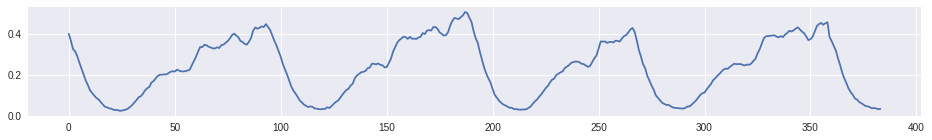

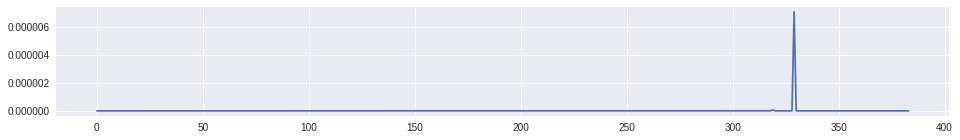

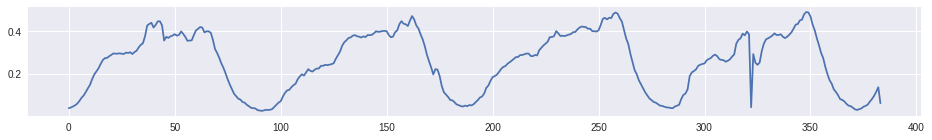

In [3]:
loader = SocLoader('BITRATE_contatori_grezzi.csv')

i = 0
for float_features, int_features, targets in loader.batch_generator(batch_size=1, sequence_len=96*4):
    _ = plt.figure(figsize=(16, 2))
    _ = plt.plot(targets[:, :, 0].reshape(-1, 1))
    i +=1
    if i > 2: break

In [5]:
#%%writefile plot_some.py
def plot_some(ytrue, yhat, forecast_steps=0, max_steps = 7 * 96):
    ytrue = ytrue[:, forecast_steps :, :]
    ytrue = ytrue.reshape(-1, ytrue.shape[-1])
    yhat = yhat.reshape(-1, yhat.shape[-1])

    max_steps = 7 * 96
    num_std = 3
    error_std = 4.5
    if yhat.shape[0] > max_steps:
        ytrue = ytrue[:max_steps]
        yhat = yhat[:max_steps]

    x = np.arange(yhat.shape[0])

    plt.clf()

    plt.subplot(211)
    plt.plot(ytrue[:, 0], color='navy')
    mu = yhat[:, 0]
    plt.plot(x, mu, color='darkorange')
    plt.ylim(0, 1)

    if yhat.shape[-1] == 4:
        std = np.exp(yhat[:, 2])
        plt.fill_between(x, mu - num_std * std, mu + num_std * std, alpha=0.2, color='darkorange')
        plt.fill_between(x, mu - std, mu + std, alpha=0.3, color='darkorange')

        anomalous = mu - ytrue[:, 0] > error_std * std
        plt.plot(anomalous, color='red')

    plt.subplot(212)
    plt.plot(ytrue[:, 1], color='navy')
    mu = yhat[:, 1]
    plt.plot(x, mu, color='darkorange')
    plt.ylim(0, 1)

    if yhat.shape[-1] == 4:
        std = np.exp(yhat[:, 3])
        plt.fill_between(x, mu - num_std * std, mu + num_std * std, alpha=0.2, color='darkorange')
        plt.fill_between(x, mu - std, mu + std, alpha=0.3, color='darkorange')

        anomalous = mu - ytrue[:, 1] > error_std * std
        plt.plot(anomalous, color='red')

## Differnza fondamentale tra i frameworks di deep learning e altri package di ML

- Tutti i toolkit di ML che trovate come scikit-learn, xgboost, liblinear-svm, ecc. sono delle librerie con interfacce, parametri di tuning, ecc. ma vanno usate così come sono.


- I frameworks di deep-learning come **tensorflow** e **pytorch** forniscono dei **mattoncini** base su cui possiamo create tutti i modelli che vogliamo, con tutte le architetture più disparate.

- Si possono vedere come delle astrazioni per calcoli matriciali (tensoriali) super-veloci grazie all'uso della GPU.


- Implementano la back-propagation del gradiente durante il training in modo automatico senza dover definire a mano le derivate delle funzioni nel grafo della rete.


- Possiamo addirittura usarli senza definire alcuna rete neurale ma come semplici esecutori di operazioni su matrici. Tanto è vero che stanno iniziando a scrivere algoritmi di SVN, random forests, k-means clustering con tensorflow.

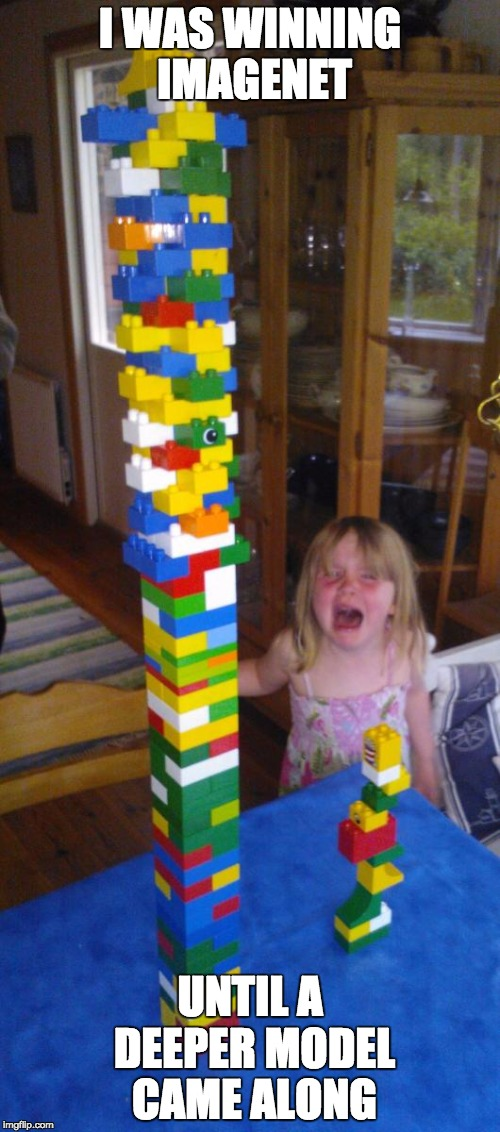

In [4]:
Image('pics/deep_net.jpg', width=350)

## Custom loss function
- Ricordate che vogliamo un modello che impara il processo che ha generato i dati.


- Poi durante l'esercizio se osserviamo un dato che si discosta in modo _improbabile_ dal modello, lo segnalamo come anomalo.


- Ora dobbiamo tradurre in linguaggio matematico la nozione di _improbabile_. Per fare ciò assumiamo che il processo generativo che sta dietro segue una distribuzione di probababilità parametrizzata da un valore atteso e una varianza.


- Utilizzeremo il valore atteso come previsione del valore e la varianza come margine di deviazione dal valore atteso.

In Pytorch e Tensorflow è abbastanza semplice definire delle loss function custom anche se non presenti nel framework base. Ricordate che abbiamo i mattoncini e possiamo comporli in modi creativi.

Qui sotto ho definito la loss come la _negative-log-likelihood_ della distribuzione di **Laplace**.
La scelta della Laplace invece della Gaussian è che la Laplace è più robusta agli outliers (il nostro training set è contaminato da outliers).

Si può dimostrare che la Gaussiana stima il valore medio mentre la Laplace il valore mediano.

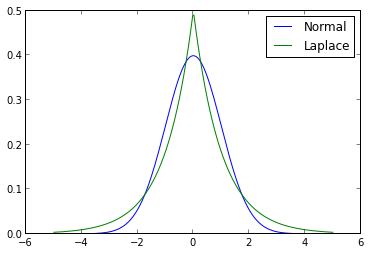

In [6]:
Image('pics/laplace.png', width=800)

In [10]:
import itertools
import torch
import torch.nn as nn

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

class LaplaceLikelihood(nn.Module):
    def __init__(self):
        super(LaplaceLikelihood, self).__init__()

    def forward(self, output, target):
        mu, log_sigma = torch.chunk(output, 2, dim=2)
        sigma = torch.exp(log_sigma)
        # log likelihood
        logp = -torch.abs(target - mu) / sigma - np.log(2) - log_sigma
        logp = torch.sum(logp, 2)
        logp = torch.mean(logp)
        return -logp


class GaussianLikelihood(nn.Module):
    def __init__(self):
        super(GaussianLikelihood, self).__init__()
    
    def forward(self, output, target):
        mu, log_sigma = torch.chunk(output, 2, dim=2)
        sigma = torch.exp(log_sigma)
        # log likelihood
        logp = -0.5 * (torch.pow((target - mu) / sigma, 2) - np.log(np.pi * 2)) - log_sigma
        logp = torch.sum(logp, 2)
        logp = torch.mean(logp)
        return -logp

Il modello impara i parametri della distribuzione (valore atteso e varianza) tramite un meccanismo noto come **Maximum Likelihood Estimation** (MLE), ossia stima i parametri che meglio spiegano le osservazioni (likelihood).

Per ogni mini batch di  $n$ osservazioni _i.i.d._ (independent and identically distributed) che assumiamo provenire da una distribuzione di probabilità parametrizzata da $\theta$, la densità congiunta è
$$ \mathcal{L}(\theta; x_1,...n_n) = f(x_1,...x_n | \theta) = \prod_{i=1}^n f(x_i | \theta) $$

Dobbiamo trovare i parametri $\theta$ che massimizzano la likelihood.
$$ \hat{\theta} = \underset{\theta}{\operatorname{argmax}} \mathcal{L}(\theta; x_1,...n_n) $$

In pratica si lavora col logaritmo della densità (log-likelihood) perché i singoli valori $f(x_i)$ sono molto piccoli e il loro prodotto diventa infinitesimo causando problemi di underflow.

Invece col logaritmo si trasformano i prodotti in somme. E siccome il log è una funzione monotona crescente, il valore $\hat{\theta}$ che massimizza log-likelihood è lo stesso che massimizza la likelihood.
$$ \hat{\theta} =\underset{\theta}{\operatorname{argmax}} {1 \over n} \sum_{i=1}^n \log f(x_i | \theta) $$

The _Laplace distribution_ has 2 parameters, $\mu$ and $\sigma > 0$ and the density function is

$$ \mathcal{L}(x;\mu, \sigma) = {1 \over 2 \sigma} \exp\left(-\frac{|x - \mu|}{\sigma}\right) $$

Note it's really similar to the _Gaussian_ density

$$ \mathcal{N}(x;\mu, \sigma^2) = {1 \over \sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right) $$

## Embedding delle features categoriche
- Le feature categoriche dobbiamo codificarle con **one-hot-encoding**.


- Tra i vari mattoncini delle reti neurali ci sono dei layer particolari detti **Categorical Embedding** che imparano a mappare una rappresentazione sparsa categorica in una rappresentazione densa.


- Uno spazio euclideo dove la distanza tra le categorie corrisponde alla loro distanza concettuale.


- Come vengono imparati questi embedding? Per effetto della propagazione del gradiente. Gli embedding sono parte della rete e sono "spinti" a imparare lo spazio euclideo che meglio descrive i dati categorici.


- È parte della magia delle reti neurali :)

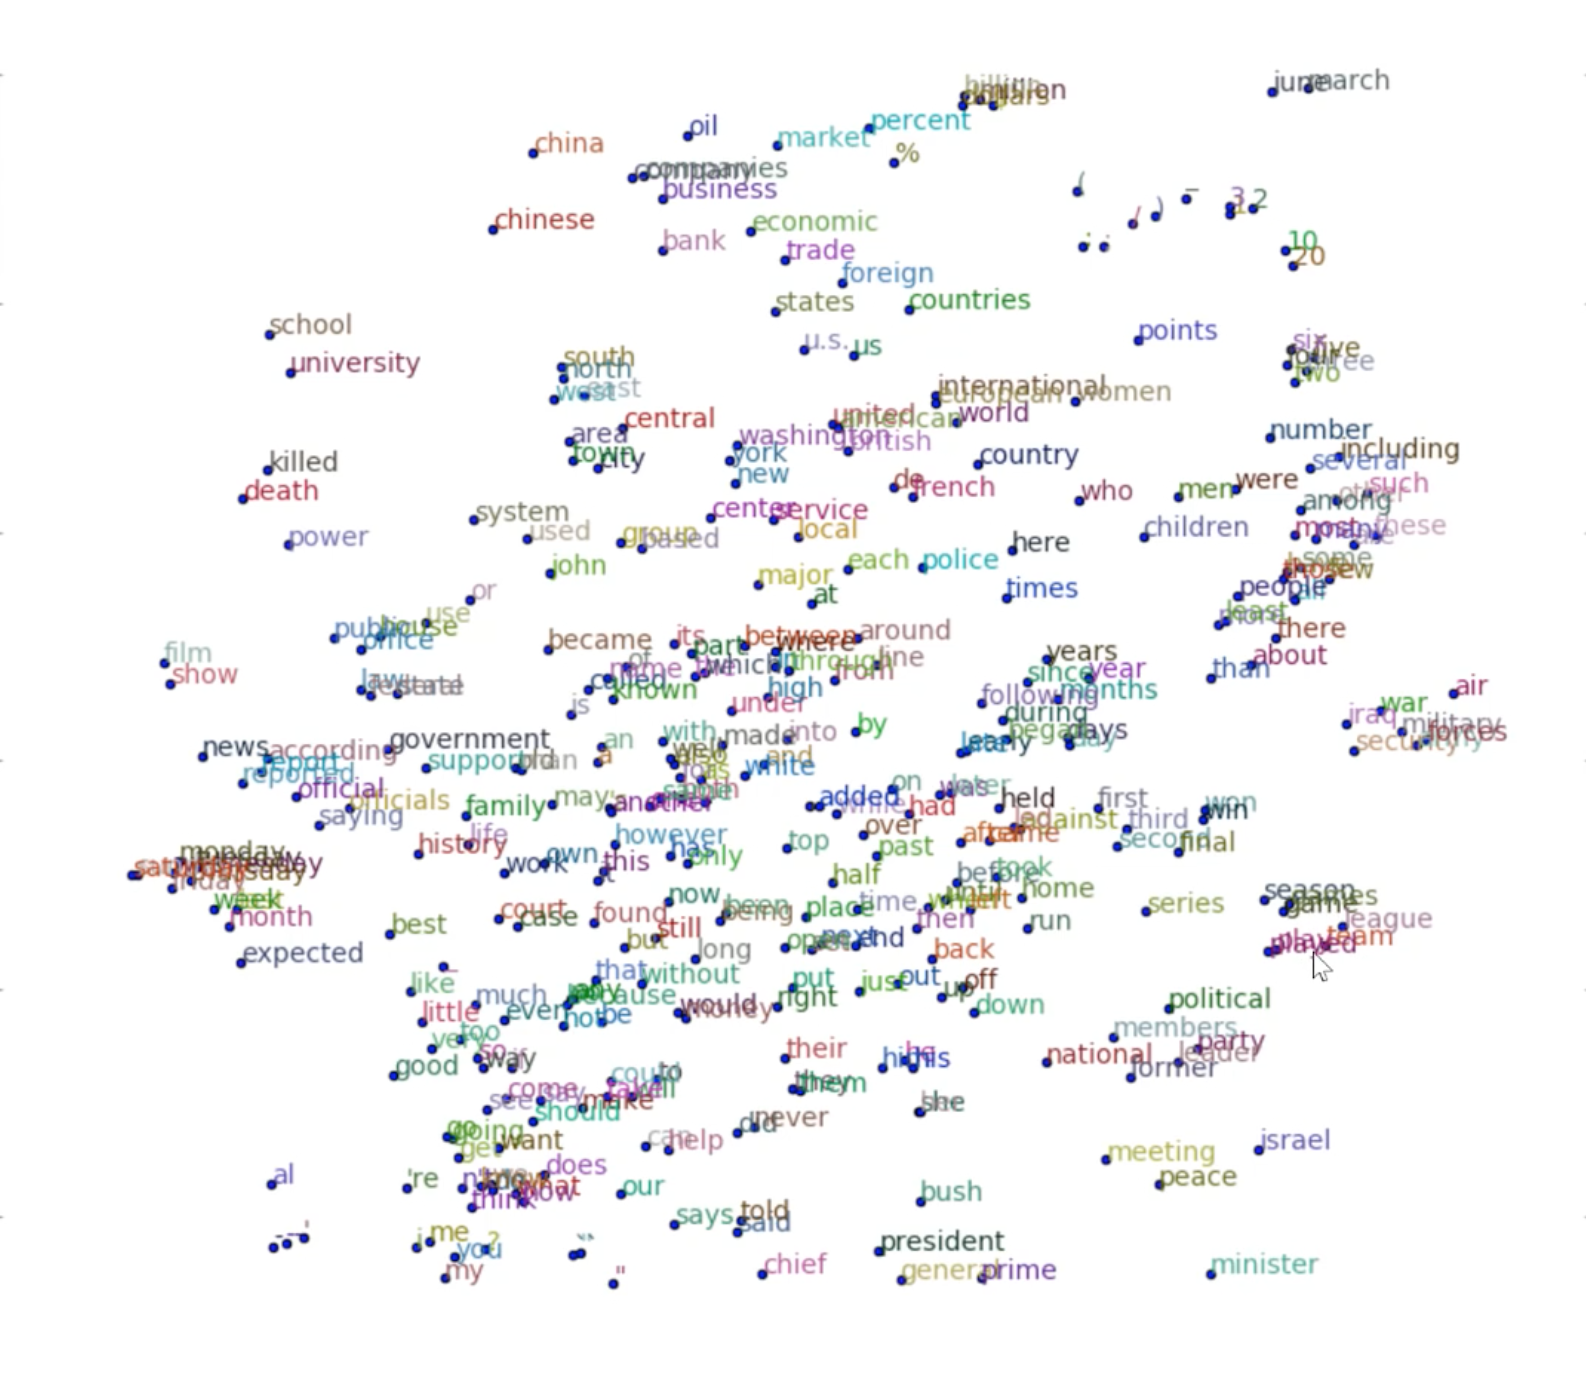

In [7]:
Image('pics/Embedding_projection.png', width=1000)

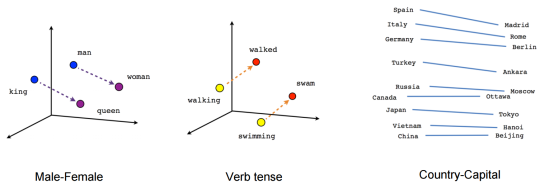

In [5]:
Image('pics/word_arithmetics.png', width=1000)

## Convolutional Neural Networks
Tutti i risultati più importanti sulle reti neurali sono stati ottenuti con 2 architetture:
1. Reti Convoluzionali
2. Reti Recurrenti

Sebbene le CNN siano soprattutto usate nel dominio delle immagini, sono adatte per lavorare con qualunque segnale.

Infatti una immagine è di fatto un segnale 2D, un video è un segnale 3D e l'audio un segnale 1D...

... e una serie temporale può essere vista come un segnale 1D.

Le CNN hanno di fatto reso inutile tutto il laboroso compito del **feature engineering** che è cruciale nel machine learning classico e che spesso richiede la maggior parte del tempo di sviluppo.

In pratica i layer convoluzionali imparano a estrarre queste features a partire dai dati grezzi.

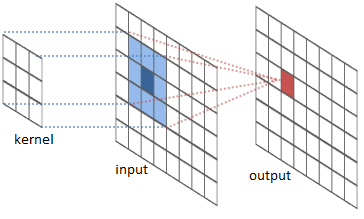

In [13]:
Image('pics/convolution_kernel.png', width=900)

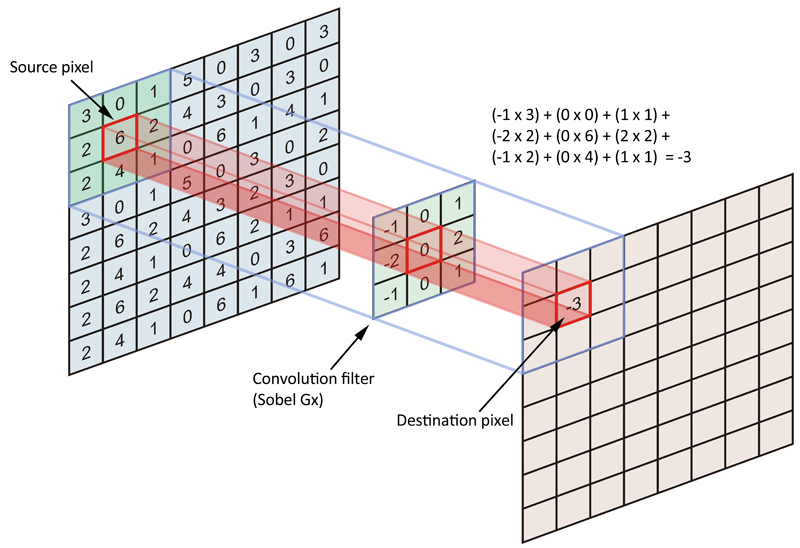

In [14]:
Image('pics/convolution_kernel2.png', width=1000)

## Convolutional Encoder-Decoder

L'architettura che ho usato è un **Convolutional Encoder-Decoder**.

Può essere stilizzato come una clessidra dove c'è un restringimento nel mezzo (_bottleneck_).

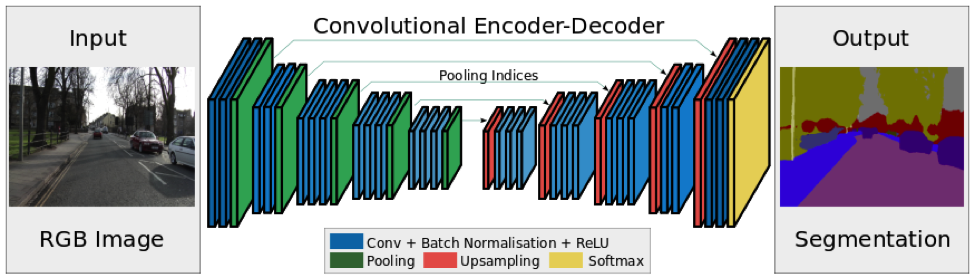

In [12]:
Image('pics/conv_autoencoder.png', width=1200)

Quale è il motivo di questa architettura?

- Se esiste qualche pattern di regolarità nei dati e non sono completamente random, questi dati "vivono" in uno spazio dimensionale molto più piccolo dello spazio di partenza (_manifold_).

- Ad esempio la distribuzione delle immagini reali, è molto più ristretta della possibili combinazioni di tutti i pizel in tutti i modi possibili $10^{14.515.206}$ (è più degli atomi dell'universo $~10^{80}$).

- Il _bottleneck_ costringe la rete a scorpire questo _manifold_ ricavando l'essenza dei dati che è quello che volgiamo per un modello generativo.

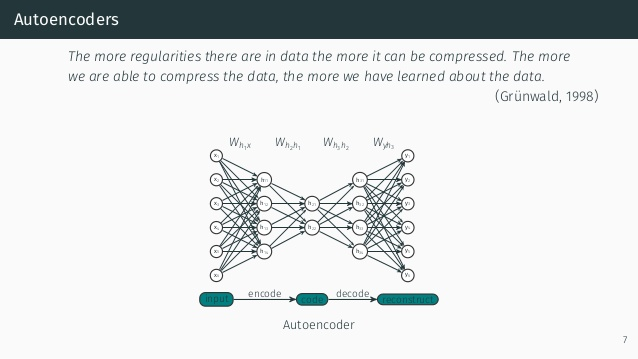

In [6]:
Image('pics/autoencoder_compression.jpg', width=1000)

In [11]:
class ConvBottleneck(nn.Module):
    def __init__(self, num_names, input_size, embed_size=3, \
                 feature_maps=(16, 32, 64, 128, 256), activation=nn.ELU()):
        super(ConvBottleneck, self).__init__()

        self.embed_week = nn.Embedding(7, embed_size)
        self.embed_name = nn.Embedding(num_names, embed_size)

        input_size += 2 * (embed_size - 1)
        modules = []
        for output_size in feature_maps:
            conv = nn.Conv1d(input_size, output_size, kernel_size=3, stride=2, padding=1)
            modules.append(conv)
            modules.append(nn.BatchNorm1d(output_size))
            modules.append(activation)
            input_size = output_size

        modules.append(nn.Dropout(0.4))
        self.conv = nn.ModuleList(modules)

        modules = []
        for input_size, output_size in pairwise(reversed((4,) + feature_maps)):
            deconv = nn.ConvTranspose1d(input_size, output_size, kernel_size=3, stride=2, \
                                        padding=1, output_padding=1)
            modules.append(deconv)
            modules.append(nn.BatchNorm1d(output_size))
            modules.append(activation)

        conv = nn.Conv1d(output_size, output_size, kernel_size=1, stride=1)
        modules.append(conv)
        self.deconv = nn.ModuleList(modules)


    def forward(self, float_features, int_features, autoregression=None):
        name = self.embed_name(int_features[:, :, 0])
        week = self.embed_week(int_features[:, :, 2])
        is_ibox = int_features[:, :, 1:2].float()

        if autoregression is None:
            features = torch.cat((float_features, name, is_ibox, week), 2)
        else:
            features = torch.cat((autoregression, float_features, name, is_ibox, week), 2)

        # in torch shape is (batch, channels, height, width)
        features = torch.transpose(features, 1, 2)

        for module in self.conv:
            new_features = module(features)
            features = new_features

        for module in self.deconv:
            new_features = module(features)
            features = new_features

        output = torch.transpose(features, 1, 2)
        return output

$$ELU(x) = \begin{cases}
x & x > 0 \\
e^x - 1 & x \leq 0
\end{cases}$$

![elu](pics/elu.png)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

file = 'BITRATE_contatori_grezzi.csv'
loader = SocLoader(file, train_test_split=0.95)

num_features = 10
model = ConvBottleneck(loader.num_names, input_size=num_features, \
                      feature_maps=(16, 32, 64, 128, 256))
model.cuda()

float features (239114, 5)
int features (239114, 3)
targets (239114, 2)


ConvBottleneck (
  (embed_week): Embedding(7, 3)
  (embed_name): Embedding(8, 3)
  (conv): ModuleList (
    (0): Conv1d(14, 16, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ELU (alpha=1.0)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): ELU (alpha=1.0)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True)
    (8): ELU (alpha=1.0)
    (9): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True)
    (11): ELU (alpha=1.0)
    (12): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
    (14): ELU (alpha=1.0)
    (15): Dropout (p = 0.4)
  )
  (deconv): ModuleList (
    (0): ConvTranspose1d(256, 128, kernel_si

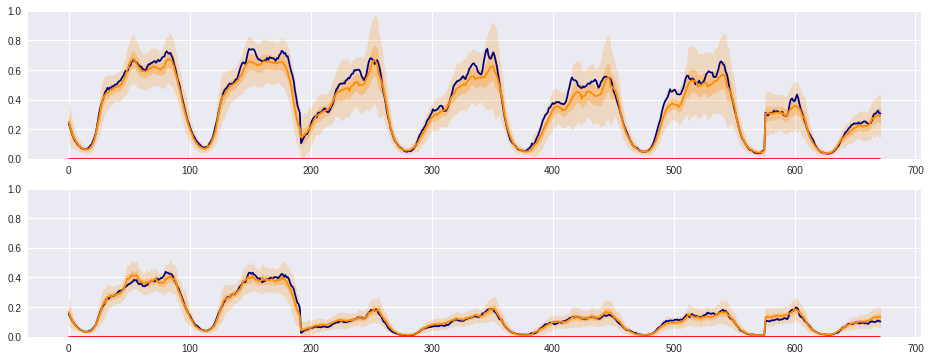

Epoch 12 train loss Variable containing:
-4.5997
[torch.cuda.FloatTensor of size 1 (GPU 0)]



KeyboardInterrupt: 

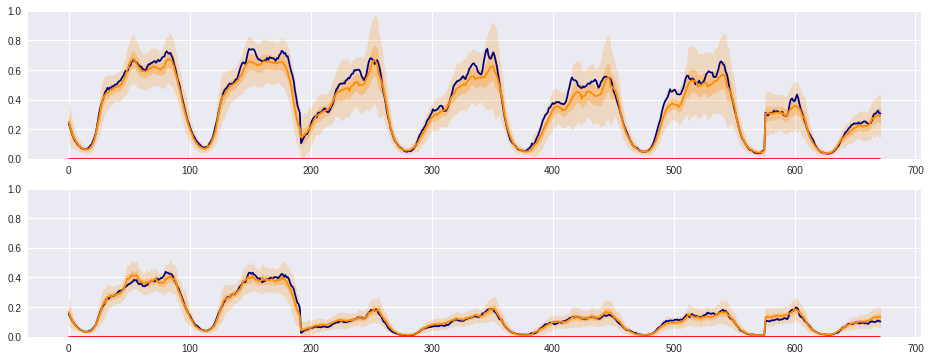

In [16]:
from IPython import display
import time

criterion = LaplaceLikelihood()
criterion.cuda()

optimizer = optim.Adam(model.parameters(), lr=5e-4)

checkpoint = torch.load(r'bottleneck_5lb.pth')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Turn on training mode which enables dropout.
model.train()

batch_size = 20
sequence_len = 96 * 3
num_epochs = 20
forecast_steps = 96


for epoch in range(num_epochs):
    total_loss = 0
    it = 0
    for float_features, int_features, targets in loader.batch_generator(
                            batch_size, sequence_len, stride=16):
        
        float_features = float_features[:, forecast_steps:, :]
        int_features = int_features[:, forecast_steps:, :]
        real_targets = targets[:, forecast_steps:, :]
        autoregression = None if forecast_steps == 0 else targets[:, :-forecast_steps, :]

        float_features_var = Variable(torch.from_numpy(float_features).cuda())
        int_features_var = Variable(torch.from_numpy(int_features).cuda())
        targets_var = Variable(torch.from_numpy(real_targets).cuda())
        autoregression_var = None if autoregression is None else Variable(torch.from_numpy(autoregression).cuda())

        model.zero_grad()

        output = model(float_features_var, int_features_var, autoregression_var)
        loss = criterion(output, targets_var)
        loss.backward()
        optimizer.step()

        total_loss += loss
        it += 1

#     torch.save({
#         'epoch': epoch + 1,
#         'state_dict': model.state_dict(),
#         'optimizer': optimizer.state_dict(),
#     }, r'bottleneck2.pth')


    plt.gca().cla() 
    plot_some(real_targets, output.data.cpu().numpy(), 0)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    print('Epoch {} train loss {}'.format(epoch + 1, total_loss / it))

#plt.close()

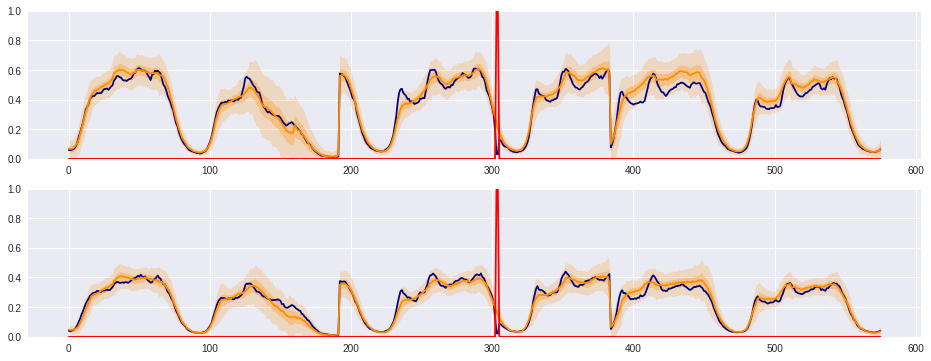

test loss Variable containing:
-4.3280
[torch.cuda.FloatTensor of size 1 (GPU 0)]



KeyboardInterrupt: 

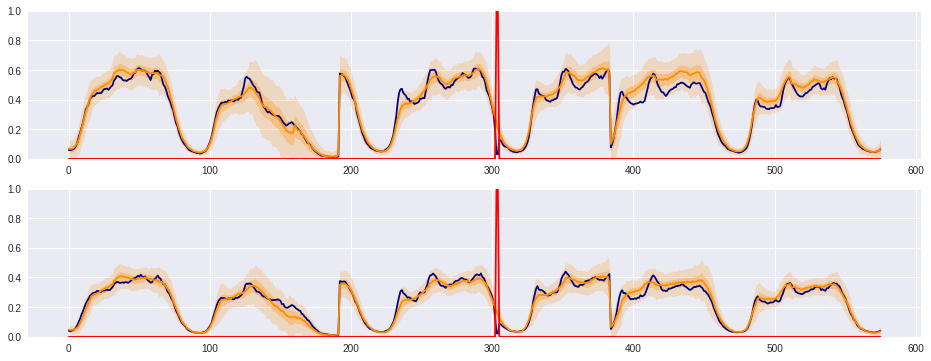

In [17]:
# sampler
checkpoint = torch.load(r'bottleneck_5lb.pth')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

for float_features, int_features, targets in loader.batch_generator(
                        3, sequence_len, training=False):
    
    float_features = float_features[:, forecast_steps:, :]
    int_features = int_features[:, forecast_steps:, :]
    real_targets = targets[:, forecast_steps:, :]
    autoregression = None if forecast_steps == 0 else targets[:, :-forecast_steps, :]

    float_features_var = Variable(torch.from_numpy(float_features).cuda(), volatile=True)
    int_features_var = Variable(torch.from_numpy(int_features).cuda(), volatile=True)
    targets_var = Variable(torch.from_numpy(real_targets).cuda(), volatile=True)
    autoregression_var = None if autoregression is None \
        else Variable(torch.from_numpy(autoregression).cuda(), volatile=True)

    output = model(float_features_var, int_features_var, autoregression_var)
    loss = criterion(output, targets_var)
        
    plt.gca().cla() 
    plot_some(real_targets, output.data.cpu().numpy(), 0)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    print('test loss {}'.format(loss))
    
    time.sleep(2.0)

In [ ]:
from graphviz import Digraph
import re


def make_dot(var):
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def add_nodes(var):
        if var not in seen:
            if isinstance(var, Variable):
                value = '('+(', ').join(['%d'% v for v in var.size()])+')'
                dot.node(str(id(var)), str(value), fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'previous_functions'):
                for u in var.previous_functions:
                    dot.edge(str(id(u[0])), str(id(var)))
                    add_nodes(u[0])
    add_nodes(var.creator)
    return dot


In [ ]:
import torchvision.models as models

inputs = torch.randn(1,3,224,224)
resnet18 = models.resnet18()
y = resnet18(Variable(inputs))
make_dot(y)